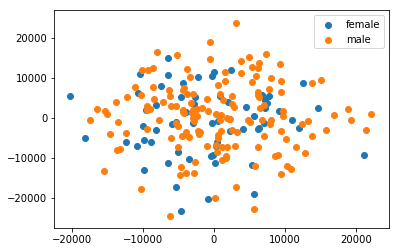

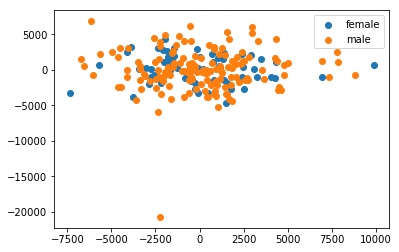

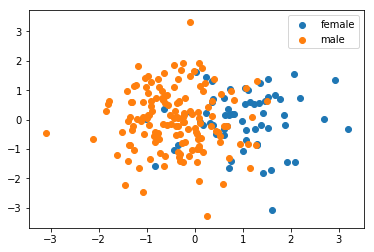

In [3]:

from numpy.random import uniform
from numpy.random import randn
import random
import time
import scipy.io as sio

import matplotlib.pyplot as plt

from scipy.linalg import eig
from scipy.linalg import sqrtm
from numpy.linalg import inv
from numpy.linalg import svd

from utils import create_one_hot_label
from utils import subtract_mean_from_data
from utils import compute_covariance_matrix

import numpy as np
import numpy.linalg as LA


import sys
from numpy.linalg import svd



class Project2D():

	'''
	Class to draw projection on 2D scatter space
	'''

	def __init__(self,projection, clss_labels):

		self.proj = projection
		self.clss_labels = clss_labels


	def project_data(self,X,Y,white=None):

		'''
		Takes list of state space and class labels
		State space should be 2D
		Labels shoud be int
		'''

		p_a = []
		p_b = []
		# p_c = []

		# Project all Data
		proj = np.matmul(self.proj,white)

		X_P = np.matmul(proj,np.array(X).T)

		for i in range(len(Y)):

			if Y[i] == 0:
				p_a.append(X_P[:,i])
			elif Y[i] == 1:
				p_b.append(X_P[:,i])
			# else:
			# 	p_c.append(X_P[:,i])


		p_a = np.array(p_a)
		p_b = np.array(p_b)
		# p_c = np.array(p_c)

		plt.scatter(p_a[:,0],p_a[:,1],label = 'female')
		plt.scatter(p_b[:,0],p_b[:,1],label = 'male')
		# plt.scatter(p_c[:,0],p_c[:,1],label = 'eggplant')

		plt.legend()

		plt.show()



class Projections():

	def __init__(self,dim_x,classes):

		'''
		dim_x: the dimension of the state space x
		classes: The list of class labels
		'''

		self.d_x = dim_x
		self.NUM_CLASSES = len(classes)



	def get_random_proj(self):
		'''
		Return A which is size 2 by 729
		'''
		A = np.random.randn(2,68)
		return A



	def pca_projection(self,X,Y):

		'''
		Return U_2^T
		'''
		one_hot_Y = create_one_hot_label(Y,self.NUM_CLASSES)
		mean_zero_X, mean_zero_Y = subtract_mean_from_data(X,one_hot_Y)
		cov_xx = compute_covariance_matrix(mean_zero_X, mean_zero_X)
		[U, S, V] = LA.svd(cov_xx, full_matrices=1, compute_uv=1)
		U_2D = U[:,0:2]
		U_2D = U_2D.T
		return U_2D




	def cca_projection(self,X,Y,k=2):

		'''
		Return U_K^T, \Simgma_{XX}^{-1/2}
		'''

		###SCALE AN IDENTITY MATRIX BY THIS TERM AND ADD TO COMPUTED COVARIANCE MATRIX TO PREVENT IT BEING SINGULAR ###
		reg = 1e-5
		one_hot_Y = create_one_hot_label(Y,self.NUM_CLASSES)
		mean_zero_X, mean_zero_Y = subtract_mean_from_data(X,one_hot_Y)

		# compute Covariance of X and Y
		cov_XX = compute_covariance_matrix(mean_zero_X,mean_zero_X)
		cov_YY = compute_covariance_matrix(one_hot_Y, one_hot_Y)
		cov_XY = compute_covariance_matrix(mean_zero_X, mean_zero_Y)

		# square root inverse of cov_xx, and cov_yy
		cov_XX_sqrt = np.linalg.inv(sqrtm(cov_XX + reg*np.eye(cov_XX.shape[0])))
		cov_YY_sqrt = np.linalg.inv(sqrtm(cov_YY + reg*np.eye(cov_YY.shape[0])))

		# canonical correlation matrix
		C = cov_XX_sqrt.dot(cov_XY).dot(cov_YY_sqrt)

		# svd of C
		[U, S, V] = LA.svd(C, full_matrices=1, compute_uv=1)
		U_k = U[:, 0:k]
		return U_k.T, cov_XX_sqrt



	def project(self,proj,white,X):
		'''
		proj, numpy matrix to perform projection
		whit, numpy matrix to perform whitenting
		X, list of states
		'''

		proj = np.matmul(proj,white)

		X_P = np.matmul(proj,np.array(X).T)

		return list(X_P.T)



if __name__ == "__main__":

	data = sio.loadmat('mat4SVM_Af_Am_volume_TCTV_age.mat')
	brain = data['mat4SVM']
	# class_label= sio.loadmat('class_Af_Am.mat')
	# label = np.zeros([202,1])
	# label[56:] = 1
	label = np.zeros([213,1])
	label[63:] = 1
	# def zerolistmaker(n):
    # 	listofzeros = [0] * n
    # 	return listofzeros

	X = list(brain)
	Y = label

	CLASS_LABELS = ['female','male']

	feat_dim = max(X[0].shape)
	projections = Projections(feat_dim,CLASS_LABELS)


	rand_proj = projections.get_random_proj()
	# Show Random 2D Projection
	proj2D_viz = Project2D(rand_proj,CLASS_LABELS)
	proj2D_viz.project_data(X,Y, white = np.eye(feat_dim))

	#PCA Projection
	pca_proj = projections.pca_projection(X,Y)

	#Show PCA 2D Projection
	proj2D_viz = Project2D(pca_proj,CLASS_LABELS)
	proj2D_viz.project_data(X,Y, white = np.eye(feat_dim))

	#CCA Projection
	cca_proj,white_cov = projections.cca_projection(X,Y)
	#Show CCA 2D Projection
	proj2D_viz = Project2D(cca_proj,CLASS_LABELS)
	proj2D_viz.project_data(X,Y,white = white_cov)
